In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 4-3 나이브 베이즈, K최근접 이웃

## 0. 데이터셋 소개

### SMS Spam dataset

[Spam](https://archive.ics.uci.edu/dataset/228/sms+spam+collection):SMS 텍스트로 메세지와 Spam 여부를 나타낸 데이터셋입니다.

|Name|Type|Description|
|----|---|---------|
|target|binary|ham or spam|
|message|text|SMS message|

텍스트를 입력으로 분류를 연습하기 위한 데이터셋입니다.

In [2]:
df_spam = pd.read_csv('data/SMSSpamCollection.tsv', sep='\t')
df_spam.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# 공백으로 문장을 나누어 단어의 수를 출력합니다.
df_spam['message'].str.split(' ').apply(len)

0       20
1        6
2       28
3       11
4       13
        ..
5567    30
5568     8
5569    10
5570    26
5571     6
Name: message, Length: 5572, dtype: int64

## 1. 나이브 베이즈(Naive Bayes)

- 베이즈 정리(Bayes' Theorem)

<div style="padding: 5px; margin-left: 20px;">

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

$P(A_i|B) = \frac{P(B|A_i)P(A_i)}{P(B)} = \frac{P(B|A_i)P(A_i)}{\sum_{\forall j}P(A_j,B)} = \frac{P(B|A_i)P(A_i)}{\sum_{\forall j}P(B|A_j)P(A_j)}$
    
</div>

-  입력 변수 $x_1, ... x_p$는 $C_j$와 조건부로 서로 독립이라고 가정하여 모델을 간소화 했습니다.

<div style="padding: 5px; margin-left: 20px;">

> $P(C_j|x_1,...,x_p) = \frac{P(x_1,...,x_p|C_j)P(C_j)}{P(x_1,...,x_p)}$
>
> $P(C_j|x_1,...,x_p) \propto P(x_1,...,x_p|C_j)P(C_j)$
    
Chain Rule에 의해,

> $P(x_1,...,x_p|C_j)P(C_j) = P(x_1|x_2,...,x_p, C_j)P(x_2|x_3,...,x_p, C_j)...P(x_p|C_j)P(C_j)$
    
입력변수가 $C_j$의 조건하에서 서로 독립이라는 가정합니다.

> $P(x_1,...,x_p|C_j)P(C_j) = P(x_1|C_j)P(x_2|C_j)...P(x_p|C_j)P(C_j)$
>
> $ = \prod_{i=1}^{p}\left(P(x_i|C_j)\right)P(C_j)$

> A,B가 C에 대하여 조건부 독립이면, $P(A|B,C) = P(A|C)$
    
</div>

이로써, 학습 과정은

학습데이터에서 각 클래스에 대한 입력 변수들의 조건부확률과 사전확률(Prior)를 구하는 것입니다.

<div style="padding: 5px; margin-left: 20px; margin-top: 10px;">

입력 변수들와 클래스의 조건부 확률: $P(x_1|C_j), P(x_2|C_j),...,P(x_p|C_j)$ 

사전 확률(Prior): $P(C_j)$
    
</div>


**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_spam에서 메세지에서 대소문자 구별하지 않고(소문자 처리) 단어를 추출합니다. 

단어의 출현 빈도가 5 이상인 것만 남기고,

출현하는 단어를 $w_1, ... w_n$ 이라고 할 때, (n은 출현 단어의 수)

$P(w_i\text{ 등장}|target=ham), P(w_i\text{ 등장}|target=spam)$을 구합니다. 

> $P(w_i\text{ 등장}|target=ham) = \frac{\text{단어 }w_i\text{가 나오는 ham 문서의 수}}{\text{ham인 문서의 수}}$,
>  
> $P(w_i\text{ 등장}|target=spam) = \frac{\text{단어 }w_i\text{가 나오는 spam 문서의 수}}{\text{spam인 문서의 수}}$

미출현 단어에 의해 확률이 0이 되지 않도록 spam과 ham에서 모든 단어의 빈도에 0.1씩 더 해줍니다.

이와 함께, $P(target=ham), P(target=spam)$ 을 구해 봅니다.

> $P(target=ham) = \frac{\text{ham인 문서의 수}}{\text{전체 문서의 수}}$
>
> $P(target=spam) = \frac{\text{spam인 문서의 수}}{\text{전체 문서의 수}}$
    
</div>

In [4]:
# message Series를 
# 1. str.lower(): 소문자로 바꿉니다. 
# 2. a-z가 1회 이상 나오는 문자열들을 추출해냅니다,
# 3. 동일 SMS에서 중복된 출현한 단어들은 한 번씩남 남도록 합니다.
# 4. explode(): list의 내용들을 풀어서 하나의 Series로 전개합니다.
s_spam_words = df_spam['message'].str.lower()\
                        .str.findall('[a-z]{1,}')\
                        .apply(lambda x : list(np.unique(x)))\
                        .explode()
s_spam_words

0           amore
0       available
0          buffet
0           bugis
0            cine
          ...    
5571          its
5571         name
5571         rofl
5571           to
5571         true
Name: message, Length: 79161, dtype: object

In [5]:
# 단어 빈도를 구합니다.
s_word_cnt = s_spam_words.value_counts()
s_word_cnt

i            2088
to           1687
you          1591
a            1190
the          1037
             ... 
upon            1
aspects         1
rajas           1
sariyag         1
someonone       1
Name: message, Length: 7785, dtype: int64

In [6]:
# 출현 빈도가 5개 이상인 단어만 선택합니다.
s_spam_words = s_spam_words.loc[s_spam_words.isin(s_word_cnt.loc[s_word_cnt >= 5].index)]
s_spam_words

0       available
0           bugis
0            cine
0           crazy
0               e
          ...    
5570         week
5571          its
5571         name
5571           to
5571         true
Name: message, Length: 69855, dtype: object

In [7]:
# 대상 변수의 빈도수를 구합니다.
s_target_cnt = df_spam['target'].value_counts()
s_target_cnt

ham     4825
spam     747
Name: target, dtype: int64

In [8]:
# 대상 변수의 출현 비율를 구합니다. (Prior)
s_target_prob = df_spam['target'].value_counts(normalize=True)
s_target_prob

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [9]:
# P(w_i|target=ham), P(w_i|target=spam)의 확률을 구합니다.

# ham과 spam별 단어 출현빈도를 구합니다.
# 빈도수가 없는 단어가 나오면 확률을 0으로 하면, 대상 변수를 분류하는데 유력한 단어가 나온다고 하더라도, 
# 빈도수가 없는 단어가 섞여 있으면 해당 클래스일 확률이 0이 됩니다.
# 이러한 문제를 완화하기 위해 빈도수가 없더라도 최소빈도수(0.1)를 넣어 줍니다.
# 전체합으로 나누어 ham, spam에 대한 조건부 확률로 만들어줍니다. 
# 이 때, 모든 단어 빈도에 더한 최소빈도수(0.1) 만큼을 df_target_cnt에 더하여 조건부 확률의 최대값이 1이 되도록합니다.

"""
# 아래와와 동일 루틴입니다.
df_word_prob = (
    pd.crosstab(index=[df_spam.loc[s_spam_words.index,'target']],columns=s_spam_words) + 0.1
).divide(s_target_cnt + 0.1, axis=0).T"""

df_word_prob = (s_spam_words.to_frame().groupby(
    df_spam.loc[s_spam_words.index, 'target']
)['message'].apply(lambda x: x.value_counts()).unstack().fillna(0).T + 0.1) / (s_target_cnt + 0.1)
df_word_prob.head()

target,ham,spam
a,0.183851,0.405702
aathi,0.001264,0.000134
abiola,0.002300,0.000134
able,0.005409,0.000134
about,0.029865,0.009503


**[Ex.2]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

단어의 출현 유무를 통해 spam/ham을 분류하는 나이브 베이즈를 이용하여 구하고자 합니다.
    
$x_i$를 SMS에 $w_i$가 등장하는 여부를 $C_j$ 를 SMS의 target이 ham/spam인 여부를 나타냅니다.
    
$\prod_{i=1}^{p}\left(P(x_i|C_j)\right)P(C_j)$  곱 연산은 곱의 수가 많아질 수록 floating point 표현 범위를 벗어날 가능성이 높습니다.

단조 증가 함수인 log를 사용을 하면 별다른 처리 없이 대소 관계를 비교할 수 있고, 
    
곱을 합으로 바꿀 수 있어, floating point 연산에 대한 안정성을 가져올 수 있습니다.
    
다음과 같이 log를 적용하여 아래의 판별함수 값을 target_ham, target_spam인 로그 확률을 만들어 봅니다.

<div style="padding: 5px; margin-left: 20px; margin-top: 10px">
$log(P(C_j|x_1,...,x_p)) \propto log(\prod_{i=1}^{p}\left(P(x_i|C_j)\right)P(C_j)) = \sum_{i=1}^plog(P(x_i|C_j)) + log(P(C_j))$
</div>

이를 기반으로 spam/ham 을 분류합니다.
</div>

In [10]:
# 문서별로 P(x_i|spam)P(spam) = 등장한 단어에서 spam일 로그 확률을 구합니다.
# 1. 문서에 등장한 단어를 spam 문서에 등장할 로그 확률로 바꿉니다.
# 2. 문서별로 확률의 합을 구합니다.
# 3. spam일 확률을 더합니다.
df_word_prob_log = np.log(df_word_prob)
s_spam_logprob = s_spam_words.map(df_word_prob_log['spam']).dropna().reset_index()\
            .groupby('index')['message'].sum() + \
            np.log(s_target_prob.loc['spam'])
s_spam_logprob

index
0       -90.732008
1       -35.419485
2       -70.843435
3       -44.802511
4       -69.673543
           ...    
5567    -65.807471
5568    -28.744702
5569    -34.698459
5570   -112.719810
5571    -15.994286
Name: message, Length: 5560, dtype: float64

In [11]:
# 문서별로 P(x_i|spam)P(ham) = 등장한 단어에서 ham일 로그 확률을 구합니다.
# 1. 문서에 등장한 단어를 ham 문서에 등장할 로그 확률로 바꿉니다.
# 2. 문서별로 확률의 합을 구합니다.
# 3. spam일 확률을 더합니다.
s_ham_logprob = s_spam_words.map(df_word_prob_log['ham']).dropna().reset_index()\
            .groupby('index')['message'].sum() + \
            np.log(s_target_prob.loc['ham'])
s_ham_logprob

index
0       -78.296232
1       -21.688316
2      -132.949220
3       -29.549207
4       -46.526959
           ...    
5567   -128.425125
5568    -21.004267
5569    -27.172805
5570    -87.335977
5571    -15.006446
Name: message, Length: 5560, dtype: float64

In [12]:
# spam일 확률과 ham일 확률을 비교하여 클래스 예측을 합니다.
# 5회 이상 출현하지 않아, 단어기반 확률을 구할 수 없는 경우는 빈도가 높은 'ham'으로 예측합니다.
df_spam_result = df_spam.assign(
    target_prd = pd.Series(np.where(s_spam_logprob > s_ham_logprob, 'spam', 'ham'), index=s_spam_logprob.index)
).fillna('ham')
# 오분류 데이터를 출력합니다.
df_spam_result.loc[
    df_spam_result['target'] != df_spam_result['target_prd']
]

,target,message,target_prd
45,ham,No calls..messages..missed calls,spam
68,spam,"Did you hear about the new ""Divorce Barbie""? I...",ham
69,ham,I plane to give on this month end.,spam
74,ham,U can call me now...,spam
180,ham,Hi! You just spoke to MANEESHA V. We'd like to...,spam
...,...,...,...
5157,ham,K k:) sms chat with me.,spam
5202,ham,WOT STUDENT DISCOUNT CAN U GET ON BOOKS?,spam
5315,ham,Hahaha..use your brain dear,spam
5475,ham,Dhoni have luck to win some big title.so we wi...,spam


In [13]:
# 예측 정확도 입니다.
np.mean(df_spam_result['target'] == df_spam_result['target_prd'])

0.9766690595836325

**sklearn.naive_bayes.MultinomialNB** 

입력 변수가 명목형 데이터에서 범주의 특징을 나타내는 이산형(discrete) 변수일 때 사용합니다. 

위의 예제에서는 모든 입력 변수들이 문장에 등장하는 단어의 빈도수를 의미합니다.


**주요 하이퍼 파라메터**

|이름|설명|
|---|-----|
|alpha|가법 평활화(Additive Smoothing) 평활 계수 입니다.|

- 가법 평활화

<div style="padding: 5px; margin-left: 20px;">

$\hat{\theta}_{ci} = \frac{ N_{ci} + \alpha}{N_c + \alpha n}$
    
> $\alpha$가 작을 수록 평활화가 적게 적용 되어 학습 데이터를 더 반영하고, 클수록 평활화가 크게 적용 되어 학습 데이터를 덜 반영하게 됩니다.
>
> $N_{ci} = \sum_{i=1}^{c} x_i$ 클래스 c에서 i 속성이 등장한 수입니다.
>   
> $N_{c} = \sum_{i=1}^{n} N_{ci}$ 클래스 c에서 등장한 속성의 총합입니다. 
    
</div>

**[Ex.3]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_spam에서 80%를 학습 데이터 df_train으로 나머지 20%는 평가 데이터는 df_test로 나누어 봅니다. 

최소한 5건의 메세지에 등장한 단어의 빈도를 입력 변수(속성)으로 사용하여 target 변수를 예측하는 나이브 베이즈 모델을 만듭니다.

단어의 빈도 측정은 df_train을 대상으로 합니다.

이 때, 가법 평활 계수는 1로 합니다. 성능 측정 기준은 f1_score 입니다. Positive는 spam 클래스 입니다.
    
</div>

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_spam, train_size=0.8, random_state=123)

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

clf_nb = make_pipeline(
    CountVectorizer(lowercase=True, min_df=5),
    MultinomialNB(alpha=1)
)
clf_nb.fit(df_train['message'], df_train['target'])
(
    f1_score(df_test['target'], clf_nb.predict(df_test['message']), pos_label='spam'),
    f1_score(df_train['target'], clf_nb.predict(df_train['message']), pos_label='spam')
)

(0.9442622950819671, 0.957841483979764)

**[Ex.4]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_spam에서 80%를 학습 데이터 df_train으로 나머지 20%는 평가 데이터는 df_test로 나누어 봅니다. 

최소한 5건의 메세지에 등장한 단어의 빈도를 입력 변수(속성)으로 사용하여 target 변수를 예측하는 나이브 베이즈 모델을 만듭니다.

단어의 빈도 측정은 df_train을 대상으로 합니다.

가법 평활 계수가 아래 리스트에 따라 변할 때, 학습 데이터와 평가 데이터의 성능 비교를 해봅니다. 성능 측정 기준은 AUC(Area Under the receiver characteristic Curve)입니다. Positive는 spam 클래스 입니다.

```
    alphas = [0.5, 0.8, 1.0, 1.2, 1.5]
``` 
    
</div>

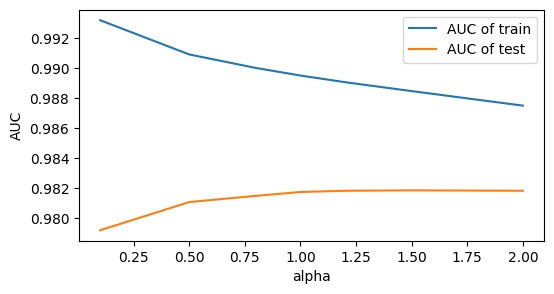

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

alphas = [0.1, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
auc_train, auc_test = list(), list()
for alpha in alphas:
    clf_nb = make_pipeline(
        CountVectorizer(lowercase=True, min_df=5),
        MultinomialNB(alpha=alpha)
    )
    clf_nb.fit(df_train['message'], df_train['target'])
    auc_test.append(
        roc_auc_score(df_test['target'], clf_nb.predict_proba(df_test['message'])[:, 1])
    )
    auc_train.append(
        roc_auc_score(df_train['target'], clf_nb.predict_proba(df_train['message'])[:, 1])
    )
plt.figure(figsize=(6, 3))
plt.plot(alphas, auc_train, label='AUC of train')
plt.plot(alphas, auc_test, label='AUC of test')
plt.gca().set_xlabel('alpha')
plt.gca().set_ylabel('AUC')
plt.legend()
plt.show()

## 나이브 베이즈의 장단점

### 장점

- 간단하고 학습이 빠릅니다.


- 상대적으로 적은 양의 훈련 데이터로도 효과성이 높습니다.


- 동일한 척도의 여러 속성을 지닌 데이터(ex. 텍스트 분류, 추천...)에 강점이 있습니다.


### 단점

- 조건부 독립이라는 가정이 실제로는 부적절한 경우가 많습니다.


## 2. K 최근접 이웃 모델

K 최근접 이웃은 학습 데이터를 저장해두고, 입력 데이터에서 근접한 K개의 데이터를 뽑아 예측을 합니다.

> 최근접 이웃의 수 K와 근접도를 나타내는 거리 측정 방법이 주요 구성 요소입니다.

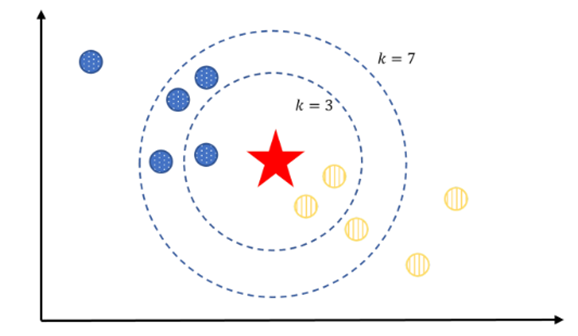

**특징**

최근접 이웃의 수를 늘릴 수록 편향은 증가하고 분산을 감소합니다.


### 분류

K 개의 근접 이웃에 해당하는 학습 데이터에서 다수의 클래스를 예측값으로 합니다. 

> 클래스의 수가 동일할 경우에는 전체셋에 대해 다수의 셋을 사용합니다.

### 회귀

K 개의 근접 이웃에 해당하는 대상 변수의 평균을 예측값으로 합니다.

**sklearn.neighbors.KNeighborsClassifier, KNeighborsRegressor**

**주요 하이퍼 파라메터**

|이름|설명|
|---|-----|
|n_neighbors|근접 이웃 수(K)|
|metric|거리 측정 방법|

**[Ex.3]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

위 예제에서 모델을 K-최근접 이웃모델로 바꾸고 근접이웃의 수를 아래 리스트에 따라 바꿀 때, df_train과 df_test의 성능 변화를 관찰해봅니다. 

성능 측정 지표는 Accuracy입니다.

```
n_neighbors_list = [1, 3, 5, 10, 20, 50, 100]
```
    
</div>

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

cvec = CountVectorizer(lowercase=True, min_df=5)
X_train = cvec.fit_transform(df_train['message'])
X_test =cvec.transform(df_test['message'])
n_neighbors_list = [1, 3, 5, 10, 20, 50, 100]
acc_train, acc_test = list(), list()

for i in n_neighbors_list:
    clf_knn = KNeighborsClassifier(
        n_neighbors=i,
        metric='euclidean'
    )
    clf_knn.fit(X_train, df_train['target'])
    acc_test.append(
        accuracy_score(df_test['target'], clf_knn.predict(X_test))
    )
    acc_train.append(
        accuracy_score(df_train['target'], clf_knn.predict(X_train))
    )

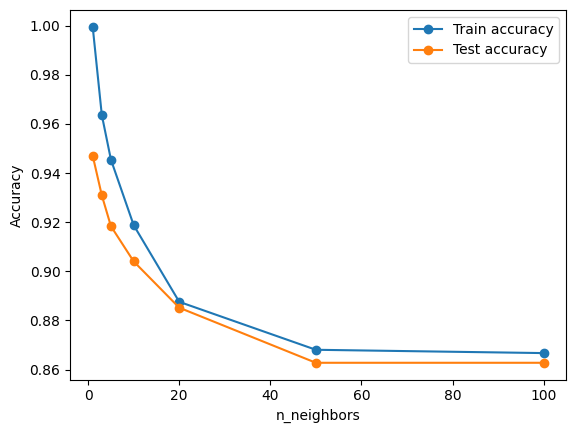

In [18]:
plt.plot(n_neighbors_list, acc_train, label='Train accuracy', marker='o')
plt.plot(n_neighbors_list, acc_test, label='Test accuracy', marker='o')
plt.gca().set_xlabel('n_neighbors')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

### K-최근접 이웃의 장단점

#### 장점

- 간단하고 이해하기 쉽습니다.


- 데이터 탑재 외에는 학습 과정이 필요하지 않아 빠르고 간단하게 모델을 완성할 수 있습니다.

#### 단점

- 데이터의 수가 많아 질수록 예측시 계산 비용이 높아집니다.


- 입력 변수(속성)의 수가 많아질수록 성능 저하의 여지가 크고, 이를 대응하기 위한 학습 데이터의 필요량이 속성이 많아질 수록 커집니다.


- 데이터가 특정 공간에 몰려 있거나, 드문드문 배치되었을 때, 지엽적으로 성능의 편차가 발생합니다.